Imports

In [7]:
#Data science imports
import numpy as np
import pandas as pd
import matplotlib
import scipy
import re
from datasets import load_dataset, Dataset

In [8]:
#NLP imports
from num2words import num2words
import nltk; nltk.download('punkt'); nltk.download('stopwords'); nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GUPTAAKI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GUPTAAKI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GUPTAAKI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
# ML imports
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



In [10]:
# DL imports
from transformers import AutoTokenizer, TrainingArguments, Trainer
from torch.utils.data import DataLoader
import evaluate

Code Settings

In [11]:
config_dict = {'source_of_dataset': "json",
               'json_url': "https://huggingface.co/datasets/medalpaca/medical_meadow_health_advice/raw/main/medical_meadow_health_advice.json",
               'db_name': "medalpaca/medical_meadow_health_advice",
               'do_preprocessing': True,
               'do_enhanced_preprocessing': False,
               'do_feature_eng': True,
               'maximize_a_priori': False,
               'num_chosen_features_per_class': 200,
               'test_size': 0.25,
               'feature_eng_details': "CountVectorizer-binary",
               'ngram_range_min': 1,
               'ngram_range_max': 3,
               'max_features': 1000,
               'seed': 0}

Gathering the data

In [14]:
# Taking the dataset either via the datasets package or directly from a URL:
if config_dict["source_of_dataset"] == "datasets package":
  dataset_raw = load_dataset(config_dict["db_name"])
  dataset_df = pd.DataFrame(dataset_raw["train"])
elif config_dict["source_of_dataset"] == "json":
  # For this particualr dataset, the owners posted a .json file to accomodate the dataset:
  dataset_df = pd.read_json(config_dict["json_url"])

In [15]:
dataset_df

instruction  \
0     Question: is this a 2) strong advice, 1) weak ...   
1     Question: is this a 2) strong advice, 1) weak ...   
2     Question: is this a 2) strong advice, 1) weak ...   
3     Question: is this a 2) strong advice, 1) weak ...   
4     Question: is this a 2) strong advice, 1) weak ...   
...                                                 ...   
8671  Question: is this a 2) strong advice, 1) weak ...   
8672  Question: is this a 2) strong advice, 1) weak ...   
8673  Question: is this a 2) strong advice, 1) weak ...   
8674  Question: is this a 2) strong advice, 1) weak ...   
8675  Question: is this a 2) strong advice, 1) weak ...   

                                                  input                 output  
0     As we have previously shown an additional effe...      This is no advice  
1     Furthermore, gut microbiota analysis in mice t...      This is no advice  
2     Further research is recommended that may be he...      This is no advice  
3     Further study will be necessary to test if pos...      This is no advice  
4     On the other hand, rheumatoid factor and Epste...      This is no advice  
...                                                 ...                    ...  
8671  Eating competence is associated with a healthy...  This is a weak advice  
8672  Gait variability reductions with noise were si...      This is no advice  
8673  Group 1 consisted of 12 patients who (after ve...      This is no advice  
8674  Participants were evaluated for their self-med...      This is no advice  
8675  Using a split litter design, we generated stre...      This is no advice  

[8676 rows x 3 columns]

Processing the Data

In [16]:
dataset_df["_label_"] = dataset_df["output"]
dataset_df["text"] = dataset_df["input"]
dataset_df = dataset_df[["text", "_label_"]]


In [17]:
dataset_df.head(4).style.set_properties(**{'text-align': 'left'})

In [18]:

print("Distribution of original labels:\n")
dataset_df[["_label_"]].value_counts()

Distribution of original labels:



_label_                
This is no advice          6477
This is a weak advice      1338
This is a strong advice     861
Name: count, dtype: int64

In [19]:
# While one could train a multi-class classification model that would diffrentiate between all 3 labels, we will reduce this to to being a binary classification problem.
# We are going to unite the two labels that indicate an advice so to have a binary decision: Whether a text represents and advice or not.
# So we are going to re-label:

# Label 0: Not an advice
# Label 1: An advice

# So now the classification problem is a binary classification problem.

Picking the class to be targeted

In [20]:
dataset_df_binary = dataset_df.copy()
dataset_df_binary["_label_"] = dataset_df["_label_"].map({"This is no advice":0}).fillna(1).map(int)

In [21]:
print("Distribution of new labels:\n")
frequencies = dataset_df_binary[["_label_"]].value_counts()
frequencies

Distribution of new labels:



_label_
0          6477
1          2199
Name: count, dtype: int64

In [44]:
# testing code : 
# gives the index of the frequencies Series,
# which is an Index object containing the labels of the classes, 
# in order of their frequency (highest first).
print(frequencies.index)

MultiIndex([(0,),
            (1,)],
           names=['_label_'])


In [45]:
# testing code :
# The slice frequencies.index[:] effectively returns the entire index.
# When you then take [0], it gives you the first element of this Index object.
print(frequencies.index[:][0])

(np.int64(0),)


In [46]:
# testing code
print(frequencies.index[:][0][0])

0


In [43]:
# Recognizing the most frequent class.
# This establish a baseline accuracy (a prior) for this dataset:

In [47]:
most_frequent_class = frequencies.index[:][0][0]
print("The most frequent class is:", most_frequent_class)
print("And its baseline accuracy is:", round((dataset_df_binary["_label_"] == most_frequent_class).mean(), 3))
     

The most frequent class is: 0
And its baseline accuracy is: 0.747


Preporcessing

In [48]:
def digits_to_words(match):
  """
  Convert string digits to the English words. The function distinguishes between
  cardinal and ordinal.
  E.g. "2" becomes "two", while "2nd" becomes "second"

  Input: str
  Output: str
  """
  suffixes = ['st', 'nd', 'rd', 'th']
  # Making sure it's lower cased so not to rely on previous possible actions:
  string = match[0].lower()
  if string[-2:] in suffixes:
    type='ordinal'
    string = string[:-2]
  else:
    type='cardinal'

  return num2words(string, to=type)


def spelling_correction(text):
    """
    Replace misspelled words with the correct spelling.

    Input: str
    Output: str
    """
    corrector = Speller()
    spells = [corrector(word) for word in text.split()]
    return " ".join(spells)


def remove_stop_words(text):
    """
    Remove stopwords.

    Input: str
    Output: str
    """
    stopwords_set = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word not in stopwords_set])


def stemming(text):
    """
    Perform stemming of each word individually.

    Input: str
    Output: str
    """
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])


def lemmatizing(text):
    """
    Perform lemmatization for each word individually.

    Input: str
    Output: str
    """
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])




def preprocessing(input_text):
  """
  This function represents a complete pipeline for text preprocessing.

  Input: str
  Output: str
  """
  output = input_text
  # Lower casing:
  output = output.lower()
  # Convert digits to words:
  # The following regex syntax looks for matching of consequtive digits tentatively followed by an ordinal suffix:
  output = re.sub(r'\d+(st)?(nd)?(rd)?(th)?', digits_to_words, output, flags=re.IGNORECASE)
  # Remove punctuations and other special characters:
  output = re.sub('[^ A-Za-z0-9]+', '', output)

  if config_dict["do_enhanced_preprocessing"]:
    # Spelling corrections:
    output = spelling_correction(output)

  # Remove stop words:
  output = remove_stop_words(output)

  if config_dict["do_enhanced_preprocessing"]:
    # Stemming:
    output = stemming(output)
    # Lemmatizing:
    output = lemmatizing(output)

  return output

In [49]:
dataset_clean = dataset_df_binary.copy()
if config_dict["do_preprocessing"]:
  dataset_clean["text"] = [preprocessing(text) for text in dataset_clean["text"]]

In [50]:
dataset_clean[["text", "_label_"]].head(10).style.set_properties(**{'text-align': 'left'})

Preliminary data exploration

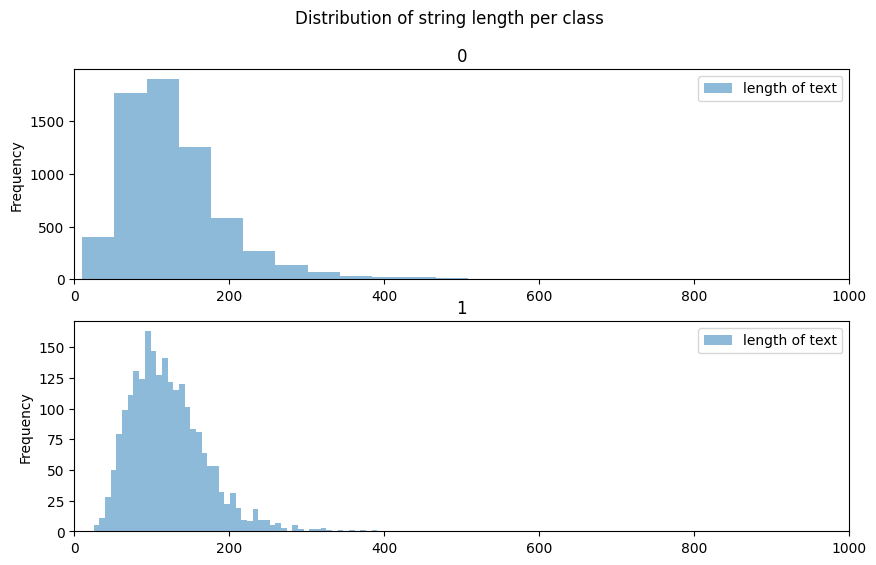

In [52]:
dataset_clean["length of text"] = dataset_clean["text"].map(len)
ax = dataset_clean.plot.hist(column=["length of text"], by="_label_", bins=50, alpha=0.5, figsize=(10, 6), title="Distribution of string length per class", xlim=[0, 1000])

Feature engineering

In [53]:
def feat_eng_text_df(in_df, text_col, labels_col, config_dict):
  if "CountVectorizer-binary" == config_dict["feature_eng_details"]:
    print("Feature Engineering method: Binary (one hot encoding)")
    countvectorizer = CountVectorizer(ngram_range=(config_dict["ngram_range_min"], config_dict["ngram_range_max"]),
                                      stop_words='english',
                                      max_features=config_dict["max_features"],
                                      binary=True)

  elif "CountVectorizer-BOW" == config_dict["feature_eng_details"]:
    print("Feature Engineering method: Bag of words")
    countvectorizer = CountVectorizer(ngram_range=(config_dict["ngram_range_min"], config_dict["ngram_range_max"]),
                                      stop_words='english',
                                      max_features=config_dict["max_features"],
                                      binary=False)

  out_arr = countvectorizer.fit_transform(in_df[text_col])
  count_tokens = countvectorizer.get_feature_names_out()
  out_df = pd.DataFrame(data = out_arr.toarray(),columns = count_tokens)
  out_df[labels_col] = list(in_df[labels_col])
  return out_df


if config_dict["do_feature_eng"]:
  dataset_feat_eng = feat_eng_text_df(dataset_clean, 'text', '_label_', config_dict)
else:
  # This option isn't being supported, the notebook would fail. This option is
  # here to cater for a ML pipeline that uses deep learning language models that consume text, and not engineered features.
  dataset_feat_eng = dataset_clean.copy()

Feature Engineering method: Binary (one hot encoding)


Exploring the new numerical features

In [54]:
dataset_feat_eng.head()

abdominal  ability  able  abnormal  abnormalities  absence  acceptable  \
0          0        0     0         0              0        0           0   
1          0        0     0         0              0        0           0   
2          0        0     0         0              0        0           0   
3          0        0     0         0              0        0           0   
4          0        0     0         0              0        0           0   

   access  according  account  ...  wide  women  word  work  year  years  \
0       0          0        0  ...     0      0     0     0     0      0   
1       0          0        0  ...     0      0     0     0     0      0   
2       0          0        0  ...     0      0     0     0     0      0   
3       0          0        0  ...     0      0     0     0     0      0   
4       0          0        0  ...     0      0     0     0     0      0   

   young  younger  zeroone  _label_  
0      0        0        0        0  
1      0        0        0        0  
2      0        0        0        0  
3      0        0        0        0  
4      0        0        0        0  

[5 rows x 1001 columns]

In [55]:
dataset_feat_eng.describe().loc[['min', 'max', 'mean']]

abdominal   ability      able  abnormal  abnormalities   absence  \
min     0.00000  0.000000  0.000000  0.000000       0.000000  0.000000   
max     1.00000  1.000000  1.000000  1.000000       1.000000  1.000000   
mean    0.00438  0.004956  0.003688  0.003458       0.003804  0.003804   

      acceptable    access  according   account  ...      wide     women  \
min     0.000000  0.000000   0.000000  0.000000  ...  0.000000  0.000000   
max     1.000000  1.000000   1.000000  1.000000  ...  1.000000  1.000000   
mean    0.003804  0.004034   0.004841  0.006339  ...  0.002766  0.026971   

          word      work      year     years     young   younger   zeroone  \
min   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
max   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
mean  0.002651  0.006224  0.004034  0.017865  0.007492  0.003804  0.002997   

       _label_  
min   0.000000  
max   1.000000  
mean  0.253458  

[3 rows x 1001 columns]

Split to Train/Test

In [56]:
dataset_feat_eng_test = dataset_feat_eng.sample(frac=config_dict["test_size"],random_state=config_dict['seed'])
dataset_feat_eng_train = dataset_feat_eng.drop(dataset_feat_eng_test.index)
     

Preliminary statistical analysis and feasibility study

In [58]:
# Calc:
# P(feature | class)

In [59]:
## Statistics of features per class:
means_by_class = dataset_feat_eng_train.groupby(by=["_label_"]).mean().T.sort_index()
means_by_class.head()

_label_               0         1
abdominal      0.004954  0.002407
ability        0.004747  0.005415
able           0.004954  0.001805
abnormal       0.005160  0.000602
abnormalities  0.004334  0.001805

In [60]:
# Calc the ratio that reflects statistical dependence:
# P(class, feature)/(P(class)P(feature))
# And note that it could be rewritten as:
# P(class | feature)/P(class)
# Or equivalently:
# P(feature | class)/P(feature)

In [61]:
P_class = sorted([[c, np.mean(dataset_feat_eng["_label_"] == c)] for c in set(means_by_class.columns)])
P_feature = sorted([[f, np.mean(dataset_feat_eng[f] > 0)] for f in dataset_feat_eng.columns if f != "_label_"])
P_feature_inv = [[f, 1/p] for f, p in P_feature]

P_class_arr = np.array(P_class)
P_feature_arr = np.array(P_feature)
P_feature_inv_arr = np.array(P_feature_inv)
# Multiplying a "column vector" of feature probablities with a "line vector" of
# class probilities to get a matrix where each element is a product of probabilities:
P_class_prod_P_feature_inv_arr = np.outer(P_feature_inv_arr[:, 1].astype(float), P_class_arr[:, 1].astype(float))

P_class_given_feature = means_by_class.copy()
for feature_counter in range(len(P_class_given_feature)):
  for c in P_class_given_feature.columns:
    # Right hand side: P(feature | class) / P(feature)
    P_class_given_feature[c][feature_counter] = means_by_class[c][feature_counter] / P_feature_arr[feature_counter, 1].astype(float)



     

C:\Users\GUPTAAKI\AppData\Local\Temp\ipykernel_11744\1861284571.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  P_class_given_feature[c][feature_counter] = means_by_class[c][feature_counter] / P_feature_arr[feature_counter, 1].astype(float)
C:\Users\GUPTAAKI\AppData\Local\Temp\ipykernel_11744\1861284571.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"]

In [62]:
# The terms that are most indicative of class "0":

P_class_given_feature.sort_values([0], ascending=False).head(10)

_label_                  0         1
associated lower  1.685376  0.000000
metaanalysis      1.652965  0.000000
thirteen          1.566873  0.093218
twentythree       1.566873  0.000000
citation          1.566873  0.000000
median            1.525421  0.000000
verbal            1.515218  0.000000
blood pressure    1.515218  0.000000
hivone            1.504198  0.417617
abnormal          1.492260  0.174007

In [63]:
# The terms that are most indicative of class "1":

P_class_given_feature.sort_values([1], ascending=False).head(10)

_label_                  0         1
promising         0.231060  4.041458
support use       0.061749  3.960164
option            0.030874  3.735155
alternative       0.096505  3.719795
tool              0.238762  3.712154
treatment option  0.000000  3.579577
treat             0.223839  3.480144
safe              0.344368  3.279367
findings support  0.503638  3.262635
suitable          0.447678  3.262635

Feature selection

In [64]:
# This is a univariate feature selection process.
# It is based on conditional dependency between a feature being 0/1 and a class being 0/1, thus the mean value of the feature is its probability.
# Note that the process of feature selection is done on the training set.

# For each class, choose the most indicative features.
# Either maximize the:

# a-priori distribution P(feature | class), Max Liklihood
# or
# a posteriori P(class | feature), MAP

In [65]:

chosen_features = []
if config_dict["maximize_a_priori"] == True:
  classes = means_by_class.columns
  for c in classes:
    chosen_features += list(means_by_class[c].sort_values(ascending=False).index[:config_dict["num_chosen_features_per_class"] + 1])
else:
  classes = P_class_given_feature.columns
  for c in classes:
    chosen_features += list(P_class_given_feature[c].sort_values(ascending=False).index[:config_dict["num_chosen_features_per_class"] + 1])


chosen_features = list(set(chosen_features))

In [66]:

chosen_features

['offer',
 'identified',
 'suitable',
 'mice',
 'angiogenin',
 'future studies',
 'students',
 'distribution',
 'wide',
 'suggest',
 'day',
 'metastasis',
 'interval',
 'clinicaltrialsgov',
 'monitoring',
 'polymorphism',
 'efficacy',
 'strategies',
 'supports',
 'bp',
 'provides',
 'decreased',
 'commuting',
 'consideration',
 'evaluation',
 'provided',
 'cohort',
 'values',
 'rats',
 'intervention',
 'given',
 'expected',
 'physicians',
 'significance',
 'results support',
 'selection',
 'twentyseven',
 'plasma',
 'tested',
 'according',
 'approaches',
 'frequently',
 'indicate',
 'acceptable',
 'standard',
 'visual',
 'bmd',
 'initial',
 'planning',
 'pediatric',
 'crs type',
 'finally',
 'significant difference',
 'require',
 'schizophrenia',
 'treatments',
 'al',
 'taken',
 'ninetyseven',
 'make',
 'tool',
 'safe',
 'patients treated',
 'importance',
 'genes',
 'advantages',
 'cell',
 'mental health',
 'helpful',
 'findings',
 'doses',
 'avoid',
 'evidencebased',
 'samples',
 'fin

Leave only chosen features:

In [67]:

dataset_feat_eng_train_selected = dataset_feat_eng_train.filter(chosen_features + ["_label_"])
dataset_feat_eng_test_selected = dataset_feat_eng_test.filter(chosen_features + ["_label_"])

dataset_feat_eng_train_selected.head()

offer  identified  suitable  mice  angiogenin  future studies  students  \
0      0           0         0     0           0               0         0   
1      0           0         0     1           0               0         0   
2      0           0         0     0           0               0         0   
3      0           0         0     0           0               0         0   
4      0           0         0     0           0               0         0   

   distribution  wide  suggest  ...  context  providing  surgical  twentyone  \
0             0     0        0  ...        0          0         0          0   
1             0     0        0  ...        0          0         0          0   
2             0     0        0  ...        0          0         0          0   
3             0     0        0  ...        0          0         0          0   
4             0     0        0  ...        0          0         0          0   

   drug  figure  close  cancer risk  conducted  _label_  
0     0       0      0            0          0        0  
1     0       0      0            0          0        0  
2     0       0      0            0          0        0  
3     0       0      0            0          0        0  
4     0       0      0            0          0        0  

[5 rows x 403 columns]

In [69]:
dataset_feat_eng_train_selected["_label_"].value_counts()

_label_
0    4845
1    1662
Name: count, dtype: int64

Machine Learning

In [70]:
dataset_feat_eng_train_selected.head()

offer  identified  suitable  mice  angiogenin  future studies  students  \
0      0           0         0     0           0               0         0   
1      0           0         0     1           0               0         0   
2      0           0         0     0           0               0         0   
3      0           0         0     0           0               0         0   
4      0           0         0     0           0               0         0   

   distribution  wide  suggest  ...  context  providing  surgical  twentyone  \
0             0     0        0  ...        0          0         0          0   
1             0     0        0  ...        0          0         0          0   
2             0     0        0  ...        0          0         0          0   
3             0     0        0  ...        0          0         0          0   
4             0     0        0  ...        0          0         0          0   

   drug  figure  close  cancer risk  conducted  _label_  
0     0       0      0            0          0        0  
1     0       0      0            0          0        0  
2     0       0      0            0          0        0  
3     0       0      0            0          0        0  
4     0       0      0            0          0        0  

[5 rows x 403 columns]

In [71]:
x_features_train = dataset_feat_eng_train_selected.values[:, 0:-1]
y_labels_train = dataset_feat_eng_train_selected.values[:, -1]

x_features_test = dataset_feat_eng_test_selected.values[:, :-1]
y_labels_test = dataset_feat_eng_test_selected.values[:, -1]
     

Iterate over ML models

In [72]:
models = []
models.append(("Random Forest", RandomForestClassifier(random_state=config_dict['seed'])))
models.append(("LASSO", lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, random_state=config_dict['seed'])))
models.append(("KNN", KNeighborsClassifier()))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=config_dict['seed'])))
models.append(("SVM", SVC(gamma='auto', random_state=config_dict['seed'])))

results = []
names = []
best_mean_result = 0
best_std_result = 0
for name, model in models:
  kfold = StratifiedKFold()
  cv_results = cross_val_score(model, X=x_features_train, y=y_labels_train, scoring='accuracy', cv=kfold)
  results.append(cv_results)
  names.append(name)
  print(name + ": mean(accuracy)=" + str(round(np.mean(cv_results), 3)) + ", std(accuracy)=" + str(round(np.std(cv_results), 3)))
  if (best_mean_result < np.mean(cv_results)) or \
    ((best_mean_result == np.mean(cv_results)) and (best_std_result > np.std(cv_results))):
    best_mean_result = np.mean(cv_results)
    best_std_result = np.std(cv_results)
    best_model_name = name
    best_model = model
print("\nBest model is:\n" + best_model_name)

Random Forest: mean(accuracy)=0.813, std(accuracy)=0.016
LASSO: mean(accuracy)=0.844, std(accuracy)=0.017
KNN: mean(accuracy)=0.789, std(accuracy)=0.01
Decision Tree: mean(accuracy)=0.799, std(accuracy)=0.016
SVM: mean(accuracy)=0.746, std(accuracy)=0.001

Best model is:
LASSO


C:\Users\GUPTAAKI\AppData\Local\Temp\ipykernel_11744\2224076768.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  matplotlib.pyplot.boxplot(results, labels=names)


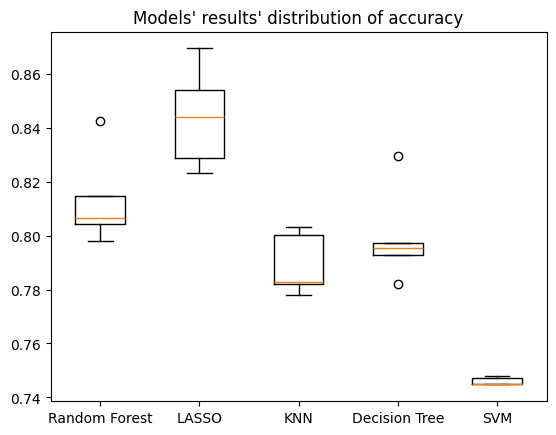

In [73]:
matplotlib.pyplot.boxplot(results, labels=names)
matplotlib.pyplot.title("Models' results' distribution of accuracy")
matplotlib.pyplot.show()

Generate the chosen model

In [76]:
# Optimize the hyperparameters:

model = lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, random_state=config_dict['seed'])
params = {"C": np.linspace(start=0.001, stop=10, num=20)}
grid_search = GridSearchCV(model, params, scoring='accuracy')
grid_search.fit(x_features_train, y_labels_train)
print("The optimal hyperparameter 'C' is:", grid_search.best_params_["C"])

The optimal hyperparameter 'C' is: 3.158578947368421


In [77]:
# Fit the optimized model to the training set:

model = lm.LogisticRegression(C=grid_search.best_params_["C"], max_iter=1000, random_state=config_dict['seed'])
model.fit(x_features_train, y_labels_train)

LogisticRegression(C=np.float64(3.158578947368421), max_iter=1000,
                   random_state=0)

Generate the ML train results: Use for Design Choices

In [78]:

y_train_estimated = model.predict(x_features_train)
accuracy_train = np.mean(y_train_estimated == y_labels_train)
baseline_accuracy_train = np.mean(0 == y_labels_train)
accuracy_lift_train = 100 * (accuracy_train/baseline_accuracy_train - 1)

print("Results on the train set for a traditional ML model:\n-------------------------")
print("Baseline (dummy classifier) accuracy:", round(baseline_accuracy_train, 2))
print("Current model's accuracy:", round(accuracy_train, 2))
print("The accuracy lift is:", round(accuracy_lift_train), "%")

Results on the train set for a traditional ML model:
-------------------------
Baseline (dummy classifier) accuracy: 0.74
Current model's accuracy: 0.88
The accuracy lift is: 18 %


Generate the ML test results: Use for presenting performance

In [79]:
y_test_estimated = model.predict(x_features_test)
accuracy_test = np.mean(y_test_estimated == y_labels_test)
baseline_accuracy_test = np.mean(0 == y_labels_test)
accuracy_lift = 100 * (accuracy_test/baseline_accuracy_test - 1)

print("Results on the test set for a traditional ML model:\n-------------------------")
print("Baseline (dummy classifier) accuracy:", round(baseline_accuracy_test, 2))
print("Current model's accuracy:", round(accuracy_test, 2))
print("The accuracy lift is:", round(accuracy_lift), "%")


print("\nConfusion Matrix:")
print(confusion_matrix(y_labels_test, y_test_estimated))
print("\nClassification Report:")
print(classification_report(y_labels_test, y_test_estimated))

Results on the test set for a traditional ML model:
-------------------------
Baseline (dummy classifier) accuracy: 0.75
Current model's accuracy: 0.85
The accuracy lift is: 13 %

Confusion Matrix:
[[1497  135]
 [ 189  348]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1632
           1       0.72      0.65      0.68       537

    accuracy                           0.85      2169
   macro avg       0.80      0.78      0.79      2169
weighted avg       0.85      0.85      0.85      2169

